In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [4]:
# %pip install scikit-learn 

In [5]:
import numpy as np
import random
import ast
import pandas as pd
import itertools
from itertools import product
import csv
from src.data_preprocessing import *
from sklearn.model_selection import train_test_split
from src.optimizers import *
from src.random_search import *
from src.train_and_evaluate import *
from src.utils import *
# from src.model_regularization import *
from src.layer import *
from src.batch_normalization import *
from loss_functions import *
from src.neural_network import *
from src.train_and_evaluate import *
from src.random_search import *
from src.k_fold_cross_validation import *
from src.early_stopping import *
# from src.ensemble_learning import *
# from src.data_split import *
# from src.model import *
np.random.seed(0)

<!-- #### Data pre-processing for MONK Datasets  -->

In [6]:
X_train, y_train = load_data(MONK_NUM=2)
X_test, y_test = load_data(MONK_NUM=2, train=False)

one hot encoded data:  (169, 17)
one hot encoded data:  (432, 17)


In [7]:
from sklearn.model_selection import train_test_split  # Ensure this import is present

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

In [8]:
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Training set overlap with validation set:",
      np.intersect1d(X_train, X_val).shape[0])

Training set size: 135
Validation set size: 34
Training set overlap with validation set: 2


In [9]:
# Print the shape of the resulting datasets
for _ in [X_train, X_val, y_train, y_val]:
    print(f"the shape: ", _.shape)

the shape:  (135, 17)
the shape:  (34, 17)
the shape:  (135, 1)
the shape:  (34, 1)


In [10]:
param_distributions = {
    'hidden_size': [[3], [4], [5], [6]],
    'hidden_activation': [[Activation_Tanh], [Activation_Leaky_ReLU], [Activation_Sigmoid], [Activation_ReLU]],
    'batch_norm': [[True], [False]],
    'learning_rate': [1e-4, 1e-3, 1e-2, 1e-1],
    'l1': [0.0, 1e-5, 1e-4, 1e-3, 1e-2],
    'l2': [0.0, 1e-5, 1e-4, 1e-3, 1e-2],
    'dropout_rate': [0.0, 0.1, 0.3],
    'batch_size': [1000],
    'n_epochs': [150, 200],
    'weight_decay': [0, 5e-2, 1e-2, 1e-3, 1e-5],
    'patience': [0, 20, 30, 50],
    'CC': [False]
    # # Define combinations of hidden layer sizes and corresponding activations
    # 'hidden_configs': [
    #     {'hidden_size': [10], 'hidden_activation': [Activation_Tanh], 'batch_norm' : [True]},
    #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
    #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
    #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
    #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_ELU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [32, 16], 'hidden_activation': [Activation_Leaky_ReLU, Activation_Sigmoid], 'batch_norm' : [False, True]},  
    #     {'hidden_size': [30, 30], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [64, 32, 16], 'hidden_activation': [Activation_ReLU, Activation_ReLU, Activation_Tanh], 'batch_norm' : [True, False, True]},
    #     {'hidden_size': [30, 30], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm': [True, False]}
    # ]   
}

TODO:

Create a seperate best_results csv file for each MONK 

In [11]:
best_hyperparams, best_performance = random_search(X_train=X_train, y_train=y_train, param_distributions=param_distributions, n_iters=30)  # adjust n_iters as needed

print(best_hyperparams)

[3] [<class 'src.activation_functions.Activation_Tanh'>] [0.0] [False]
Final Validation Accuracy: 0.6667
✅ Fold 1/5 | Validation Accuracy: 0.6667
[3] [<class 'src.activation_functions.Activation_Tanh'>] [0.0] [False]
Final Validation Accuracy: 0.5185
✅ Fold 2/5 | Validation Accuracy: 0.5185
[3] [<class 'src.activation_functions.Activation_Tanh'>] [0.0] [False]
Final Validation Accuracy: 0.4815
✅ Fold 3/5 | Validation Accuracy: 0.4815
[3] [<class 'src.activation_functions.Activation_Tanh'>] [0.0] [False]
Final Validation Accuracy: 0.3704
✅ Fold 4/5 | Validation Accuracy: 0.3704
[3] [<class 'src.activation_functions.Activation_Tanh'>] [0.0] [False]
Final Validation Accuracy: 0.4815
✅ Fold 5/5 | Validation Accuracy: 0.4815

📊 Manual K-Fold | Mean Validation Accuracy over 5 folds: 0.5037
[5] [<class 'src.activation_functions.Activation_Tanh'>] [0.0] [True]
Early stopping at epoch 23
Restoring model weights from epoch 3
Early stopping at epoch 23
Restoring model weights from epoch 3
Final V

In [12]:
print(best_hyperparams)

{'learning_rate': 0.1, 'l1': 0.0, 'l2': 0.01, 'dropout_rate': 0.0, 'batch_size': 1000, 'n_epochs': 200, 'hidden_size': [5], 'hidden_activation': ['Activation_ReLU'], 'batch_norm': [False], 'weight_decay': 1e-05, 'patience': 50, 'val_accuracy': np.float64(0.9259259259259259)}


GRID SEARCH

In [13]:
activation_map = {
    'Activation_ReLU': Activation_ReLU,
    'Activation_Tanh': Activation_Tanh,
    'Activation_ELU': Activation_ELU,
    'Activation_Leaky_ReLU': Activation_Leaky_ReLU,
    'Activation_Sigmoid': Activation_Sigmoid
}

hidden_activation = [activation_map[act] for act in best_hyperparams['hidden_activation']]  

In [16]:
if best_hyperparams.get('CC', False):
    model = CascadeCorrelation(input_size=17, output_size=1, activation=Activation_Leaky_ReLU, output_activation=Activation_Sigmoid)
else:
    model = NN(
        l1=best_hyperparams['l1'],
        l2=best_hyperparams['l2'],
        input_size=17,
        hidden_sizes=best_hyperparams['hidden_size'],
        output_size=1,
        hidden_activations=hidden_activation,
        dropout_rates=[best_hyperparams['dropout_rate']],
        use_batch_norm=best_hyperparams['batch_norm']
    )
batch_size = best_hyperparams['batch_size']
learning_rate = best_hyperparams['learning_rate']
n_epochs = best_hyperparams['n_epochs']

[5] [<class 'src.activation_functions.Activation_ReLU'>] [0.0] [False]


### Ensemble learning

In [28]:
# class EnsembleNN:
#     def __init__(self, n_models=5):
#         self.models = []
#         self.n_models = n_models
#         self.loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

#     def create_and_train_models(self, hyperparams, X_train, y_train, X_val, y_val):
#         """Create and train multiple models with diverse configurations"""

#         # Create diverse configurations for better ensemble performance
#         base_configs = [
#             {**hyperparams, 'hidden_sizes': [64,
#                                              32], 'dropout_rates': [0.2, 0.3]},
#             {**hyperparams, 'hidden_sizes': [128,
#                                              64], 'dropout_rates': [0.3, 0.4]},
#             {**hyperparams, 'hidden_sizes': [32,
#                                              16], 'dropout_rates': [0.4, 0.2]},
#             {**hyperparams,
#                 'learning_rate': hyperparams['learning_rate'] * 0.8},
#             {**hyperparams,
#                 'learning_rate': hyperparams['learning_rate'] * 1.2},
#         ]

#         for i in range(self.n_models):
#             # Use different config for each model to add diversity
#             current_config = base_configs[i % len(base_configs)]

#             # Create model with diverse architecture
#             model = NN(
#                 l1=current_config.get('l1', 0.0),
#                 l2=current_config.get('l2', 0.0),
#                 input_size=17,
#                 hidden_sizes=current_config.get(
#                     'hidden_sizes', hyperparams.get('hidden_sizes', [64])),
#                 output_size=1,
#                 hidden_activations=hidden_activation,
#                 dropout_rates=current_config.get(
#                     'dropout_rates', [hyperparams.get('dropout_rate', 0.0)]),
#                 use_batch_norm=current_config.get(
#                     'use_batch_norm', hyperparams.get('use_batch_norm', False))
#             )

#             print(f"Training model {i+1}/{self.n_models}")

#             # Create trainer instance
#             trainer = Train(hyperparameters=current_config, model=model)

#             # Add bootstrap sampling for data diversity
#             n_samples = len(X_train)
#             bootstrap_indices = np.random.choice(
#                 n_samples, n_samples, replace=True)
#             X_train_boot = X_train.iloc[bootstrap_indices] if hasattr(
#                 X_train, 'iloc') else X_train[bootstrap_indices]
#             y_train_boot = y_train.iloc[bootstrap_indices] if hasattr(
#                 y_train, 'iloc') else y_train[bootstrap_indices]

#             # Train model
#             trained_model, val_accuracy = trainer.train_and_evaluate(
#                 X_train_boot, y_train_boot, X_val, y_val
#             )

#             self.models.append(trained_model)
#             print(f"Model {i+1} validation accuracy: {val_accuracy:.4f}")

#     def predict(self, X):
#         """Make predictions using majority voting"""
#         if not self.models:
#             raise ValueError(
#                 "No trained models found. Call create_and_train_models first.")

#         predictions = []
#         for model in self.models:
#             model.forward(X, training=False)

#             # For binary classification with sigmoid output
#             if model.output.shape[1] == 1:
#                 pred = (model.output.squeeze() > 0.5).astype(int)
#             else:
#                 # For multi-class with softmax
#                 pred = np.argmax(model.output, axis=1)

#             predictions.append(pred)

#         # Majority voting
#         predictions = np.array(predictions)
#         final_predictions = np.apply_along_axis(
#             lambda x: np.bincount(x).argmax(),
#             axis=0,
#             arr=predictions
#         )
#         return final_predictions

#     def predict_proba(self, X):
#         """Get prediction probabilities from all models"""
#         if not self.models:
#             raise ValueError(
#                 "No trained models found. Call create_and_train_models first.")

#         all_probas = []
#         for model in self.models:
#             model.forward(X, training=False)
#             all_probas.append(model.output.copy())

#         # Average probabilities
#         avg_probas = np.mean(all_probas, axis=0)
#         return avg_probas

In [29]:
# # ensemble = EnsembleNN(n_models=5)

# # ensemble.create_and_train_models(best_hyperparams)

# # test_predictions = ensemble.predict(X_test)
# # test_accuracy = np.mean(test_predictions == y_test)

# # print(f"Ensemble Test Accuracy: {test_accuracy:.4f}")

# ensemble = EnsembleNN(n_models=5)

# # Pass the data to the method
# ensemble.create_and_train_models(
#     hyperparams=best_hyperparams,
#     X_train=X_train,
#     y_train=y_train,
#     X_val=X_val,
#     y_val=y_val
# )

# # Make predictions
# test_predictions = ensemble.predict(X_test)
# test_accuracy = np.mean(test_predictions == y_test)
# print(f"Ensemble Test Accuracy: {test_accuracy:.4f}")

# # Optional: Get prediction probabilities
# test_probas = ensemble.predict_proba(X_test)
# print(
#     f"Average prediction confidence: {np.mean(np.max(test_probas, axis=1)):.4f}")

Data shapes:
X_train: (135, 17), y_train: (135, 1)
Sample prediction: [[0.54760757]]
Initial loss: 0.29987404778761984
Epoch 0: Train Loss: 0.1498, Acc: 73.33% | Val Loss: 0.1603, Acc: 85.29%
Epoch 10: Train Loss: 0.1490, Acc: 73.33% | Val Loss: 0.1578, Acc: 85.29%
Epoch 20: Train Loss: 0.1490, Acc: 73.33% | Val Loss: 0.1581, Acc: 85.29%
Epoch 30: Train Loss: 0.1502, Acc: 73.33% | Val Loss: 0.1639, Acc: 79.41%
Epoch 40: Train Loss: 0.1498, Acc: 73.33% | Val Loss: 0.1650, Acc: 82.35%
Epoch 50: Train Loss: 0.1530, Acc: 73.33% | Val Loss: 0.1624, Acc: 85.29%
Epoch 60: Train Loss: 0.1497, Acc: 73.33% | Val Loss: 0.1610, Acc: 85.29%
Epoch 70: Train Loss: 0.1491, Acc: 73.33% | Val Loss: 0.1591, Acc: 85.29%
Epoch 80: Train Loss: 0.1496, Acc: 73.33% | Val Loss: 0.1596, Acc: 85.29%
Epoch 90: Train Loss: 0.1528, Acc: 73.33% | Val Loss: 0.1713, Acc: 85.29%
Epoch 100: Train Loss: 0.1499, Acc: 73.33% | Val Loss: 0.1628, Acc: 85.29%
Epoch 110: Train Loss: 0.1490, Acc: 73.33% | Val Loss: 0.1564, Acc:

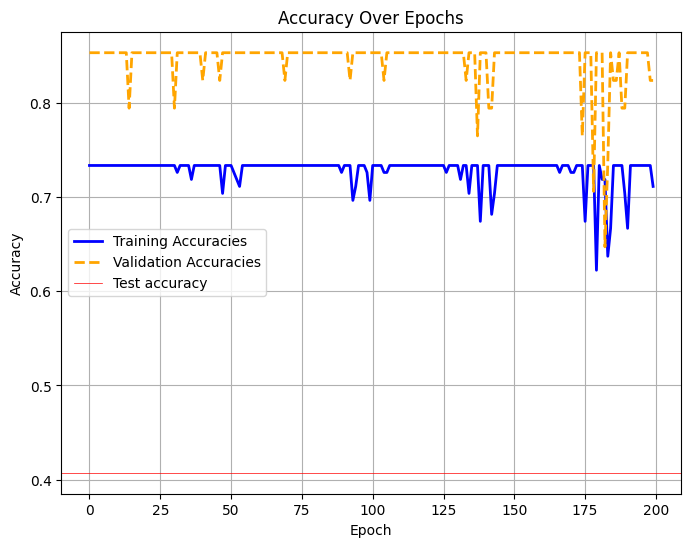

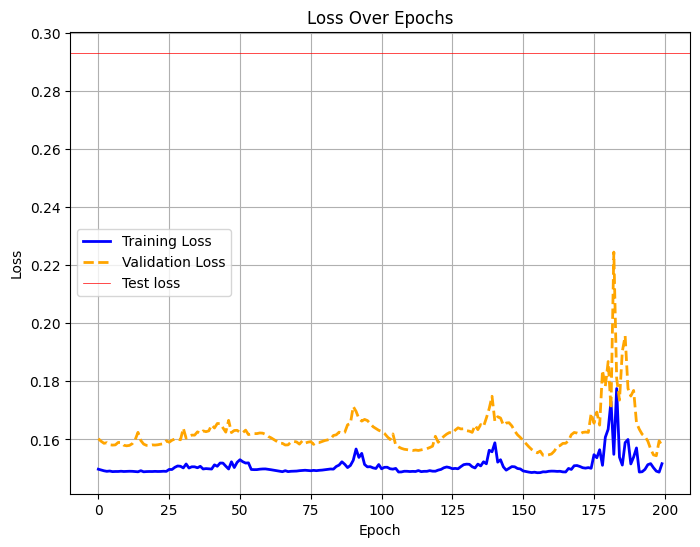

In [34]:
import copy

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

loss_function = MSE()
optimizer = Optimizer_Adam(learning_rate=learning_rate, decay=best_hyperparams['weight_decay'])

# Initialize early stopping
early_stopping = EarlyStopping(patience=100, min_delta_loss=1e-5, min_delta_accuracy=0.001)

# Before training loop:
print("Data shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Sample prediction: {model.forward(X_train[:1])}")
print(f"Initial loss: {loss_function.forward(model.output, y_train[:1])}")

# Training loop
for epoch in range(n_epochs):
    batch_losses = []
    batch_accuracies = []

    for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
        # Forward pass
        model.forward(X_batch, training=True)

        # Loss and accuracy
        loss = loss_function.forward(model.output, y_batch)
        predictions = np.round(model.output.squeeze())
        accuracy = np.mean(predictions == y_batch.squeeze())

        # Backward pass
        loss_function.backward(model.output, y_batch)
        dvalues = loss_function.dinputs

        assert dvalues.shape == model.output.shape, \
            f"Gradient shape mismatch: {dvalues.shape} vs {model.output.shape}"

        for layer in reversed(model.layers):
            layer.backward(dvalues)
            dvalues = layer.dinputs

            # Regularization
            if isinstance(layer, Layer_Dense):
                if layer.l1 > 0:
                    layer.dweights += layer.l1 * np.sign(layer.weights)
                if layer.l2 > 0:
                    layer.dweights += 2 * layer.l2 * layer.weights

        # Update weights
        optimizer.pre_update_params()
        for layer in model.layers:
            if isinstance(layer, Layer_Dense):
                optimizer.update_params(layer)
        optimizer.post_update_params()

        batch_losses.append(loss)
        batch_accuracies.append(accuracy)

    # Epoch summary
    epoch_loss = np.mean(batch_losses)
    epoch_acc = np.mean(batch_accuracies)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    X_val_input = X_val.values if isinstance(X_val, pd.DataFrame) else X_val
    y_val_input = y_val.values if isinstance(y_val, (pd.Series, pd.DataFrame)) else y_val

    model.forward(X_val_input, training=False)
    val_loss = loss_function.forward(model.output, y_val_input)
    val_predictions = np.round(model.output.squeeze())
    val_accuracy = np.mean(val_predictions == y_val.squeeze())

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: ", end="")
        print(f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc*100:.2f}% | ", end="")
        print(f"Val Loss: {val_loss:.4f}, Acc: {val_accuracy*100:.2f}%")

    # Early stopping check
    early_stopping.on_epoch_end(
        current_loss=val_loss,
        current_accuracy=val_accuracy,
        model=model,
        epoch=epoch
    )

    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch}")
        break

# Restore best weights
if early_stopping.stop_training:
    print(f"Restoring model weights from epoch {early_stopping.best_epoch}")
    early_stopping.restore_weights(model)

# Final evaluation
model.forward(X_val_input, training=False)
final_val_loss = loss_function.forward(model.output, y_val_input)
final_val_accuracy = np.mean(np.round(model.output.squeeze()) == y_val.squeeze())
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")


# Test set evaluation
model.forward(X_test, training=False)
test_loss = loss_function.forward(model.output.squeeze(), np.array(y_test))

predictions = np.round(model.output.squeeze())
y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test
test_accuracy = np.mean(predictions == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training progress
plot_accuracies(train_accuracies, val_accuracies, test_accuracy,
                label1="Training Accuracies", label2="Validation Accuracies",
                title="Accuracy Over Epochs")

plot_losses(train_losses, val_losses, test_loss,
            label1="Training Loss", label2="Validation Loss",
            title="Loss Over Epochs")

In [ ]:
print(train_losses, val_losses)

[0.29600771049822716, 0.25736314139376304, 0.24062161199299553, 0.23310743097198866, 0.2284371865986754, 0.2253574937478637, 0.22294384542137258, 0.2205165302809892, 0.21828049729513066, 0.2169839563350389, 0.21695676533635183, 0.21785278613478976, 0.21885262504485184, 0.21911474402034997, 0.21836965793990182, 0.21704306488489558, 0.21553979296785586, 0.21385926228608548, 0.2118741849287852, 0.20993992598717065, 0.20810168942308419, 0.20590784460990666, 0.20326005727206678, 0.20036442316546424, 0.19730637042044297, 0.19401190103252045, 0.1905582812346805, 0.18704094762671458, 0.18341912196375926, 0.1796149789540949, 0.1757960046391666, 0.17166196147126972, 0.1669234451639423, 0.16193577019091937, 0.15650021416594884, 0.15079595727259168, 0.1450662846555766, 0.13943468361520445, 0.13401596763373388, 0.12832983679693508, 0.12198483339217268, 0.11471188542325189, 0.10688128605238971, 0.09906022820722615, 0.09058294613029975, 0.08153434902686038, 0.07212594991109327, 0.06353650916084477, 0

In [ ]:
model.forward(X_test, training=False)
# Compute softmax probabilities for the test output
# print(X_test.shape, y_test.shape)
# print(model.output, y_test)
loss_function.forward(model.output.squeeze(), y_test)
# Calculate accuracy for the test set
predictions = np.round(model.output.squeeze())
if len(y_test.shape) == 2:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Compute test accuracy
test_accuracy = np.mean(predictions == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 1.0000


In [ ]:
# class EnsembleNN:
#     def __init__(self, n_models=5):
#         self.models = []
#         self.n_models = n_models
#         self.loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
        
            

#     def create_and_train_models(self, hyperparams):
#         # Create and train multiple models with the same hyperparameters
#         for i in range(self.n_models):
#             model = NN(
#                 l1=l1,
#                 l2=l2,
#                 input_size=17,
#                 hidden_sizes=hidden_size,
#                 output_size=1,
#                 hidden_activations=hidden_activation,
#                 dropout_rates=[dropout_rate],
#                 use_batch_norm=use_batch_norm
#             )
#             print(f"Training model {i+1}/{self.n_models}")
#             # Train model using existing train_and_evaluate function
#             model, val_accuracy = train_and_evaluate(
#                 learning_rate=hyperparams['learning_rate'],
#                 # l1=hyperparams['l1'],
#                 # l2=hyperparams['l2'],
#                 # dropout_rate=hyperparams['dropout_rate'],
#                 batch_size=hyperparams['batch_size'],
#                 n_epochs=hyperparams['n_epochs'],
#                 weight_decay=hyperparams['weight_decay'],
#                 # model=hyperparams['model']
#                 # activation=hyperparams['activation']
#                 X_train=X_train,
#                 y_train=y_train,
#                 X_val=X_val,
#                 y_val=y_val,
#                 model=model,
#             )
#             self.models.append(model)
#             print(f"Model {i+1} validation accuracy: {val_accuracy:.4f}")

#     def predict(self, X):
#         """Make predictions using majority voting"""
#         predictions = []
#         for model in self.models:
#             model.forward(X, training=False)
#             self.loss_activation.forward(
#                 model.output, np.zeros((X.shape[0], 2)))  # Dummy y values
#             pred = np.argmax(self.loss_activation.output, axis=1)
#             predictions.append(pred)

#         # Majority voting
#         predictions = np.array(predictions)
#         final_predictions = np.apply_along_axis(
#             lambda x: np.bincount(x).argmax(),
#             axis=0,
#             arr=predictions
#         )
#         return final_predictions

In [ ]:
# ensemble = EnsembleNN(n_models=5)

# ensemble.create_and_train_models(best_hyperparams)

# test_predictions = ensemble.predict(X_test)
# test_accuracy = np.mean(test_predictions == y_test)

# print(f"Ensemble Test Accuracy: {test_accuracy:.4f}")